In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis
import time
import scipy.stats
import copy
import statsmodels
from statsmodels.stats.anova import AnovaRM

root = '/usr/local/serenceslab/maggie/shapeDim/'
sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils, plot_utils, stats_utils, grid_utils

In [2]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 7
subjects = np.arange(1,8)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [3]:
lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)
    

In [4]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_checker_across_sides.npy')
dec_withintask = np.load(save_filename, allow_pickle=True).item()
dec_withintask.keys()

dict_keys(['acc_bytask', 'dprime_bytask', 'preds_all', 'probs_all', 'acc_each_cval', 'best_cval', 'roi_names'])

In [5]:
dec_withintask['acc_bytask'].shape

(7, 8, 4, 4)

In [6]:
n_trnsides = 4 # which half of the grid to train on?
trnsides = ['left','right','bottom','top']

In [7]:
roi_names = dec_withintask['roi_names']
n_rois = len(roi_names)

In [23]:
n_trialgroups = 2;

trial_group_names = ['all main','hard main']

within_side_acc = np.zeros((n_subjects, n_rois, n_tasks, n_trnsides, n_trialgroups))
across_side_acc = np.zeros((n_subjects, n_rois, n_tasks, n_trnsides, n_trialgroups))


for si, ss in enumerate(subjects):

    # loop over tasks
    for ti, tt in enumerate([1,2,3,4]):
        
        l = lab[ss][lab[ss]['task']==tt]
        
        pt_labs = np.array([l['ptx'], l['pty']]).T
        
        # category is always checkerboard task here
        categ_actual = grid_utils.get_categ(pt_labs, task_num=3)
        
        is_main_grid = l['is_main_grid']==1
        
        dist = np.array(l['dist_from_center']).round(2)
        
        hard = dist==1.13
        
        
        for tgi, allinds in enumerate([is_main_grid, \
                                    is_main_grid & hard]):



            for tri in range(n_trnsides):

                if trnsides[tri]=='left':
                    pt_inds_trn = pt_labs[:,0]<2.5
                elif trnsides[tri]=='right':
                    pt_inds_trn = pt_labs[:,0]>2.5
                elif trnsides[tri]=='bottom':
                    pt_inds_trn = pt_labs[:,1]<2.5
                elif trnsides[tri]=='top':
                    pt_inds_trn = pt_labs[:,1]>2.5

                within_inds = pt_inds_trn & allinds
                across_inds = ~pt_inds_trn & allinds

                for ri in range(n_rois):

                    pred = dec_withintask['preds_all'][si][ri][ti][tri].astype(int)

                    inds = within_inds
                    within_side_acc[si,ri,ti,tri,tgi] = np.mean(pred[inds]==categ_actual[inds])

                    inds = across_inds
                    across_side_acc[si,ri,ti,tri,tgi] = np.mean(pred[inds]==categ_actual[inds])

In [24]:
across_side_acc[si,ri,ti,tri]

array([0.46428571, 0.42857143])

Text(0.5, 1.0, 'cross-sides-all, hard main')

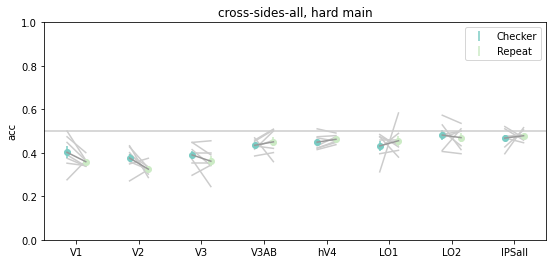

In [35]:
tgi = 1;

tgname = trial_group_names[tgi]
ti_plot = [2,3]


name = 'cross-sides-all'

vals = np.mean(across_side_acc[:,:,:,:,tgi], axis=3)
               
meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)

x_jitter = np.linspace(-0.15, 0.15, 2)

plt.figure(figsize=(9,4))

plt.axhline(0.5, color=[0.8, 0.8, 0.8])

lh = []

# non_overlapping = (cilow[:,0,ii] > cihigh[:,1,ii]) | (cilow[:,1,ii] > cihigh[:,0,ii])

for tii, ti in enumerate(ti_plot):

    x_ticks = np.arange(n_rois) + x_jitter[tii]

    plt.plot(x_ticks, meanvals[:,ti], 'o',color=task_colors[ti])
    h = plt.errorbar(x_ticks, meanvals[:,ti], \
                 semvals[:,ti], \
                 xerr=None, color=task_colors[ti], linestyle='none')
    lh.append(h)
    
for ri in range(n_rois):

    meanvals = np.mean(vals[:,ri,ti_plot], axis=0)
    plt.plot(ri+x_jitter, meanvals,'-',color=[0.6, 0.6, 0.6])

    plt.plot(ri+x_jitter, vals[:,ri,ti_plot].T, color=[0.8, 0.8, 0.8], zorder=-10)


plt.ylim([0, 1])

plt.xticks(np.arange(n_rois), roi_names)
plt.ylabel('acc')

plt.legend(lh,np.array(task_names)[ti_plot])

plt.title('%s, %s'%(name,tgname))


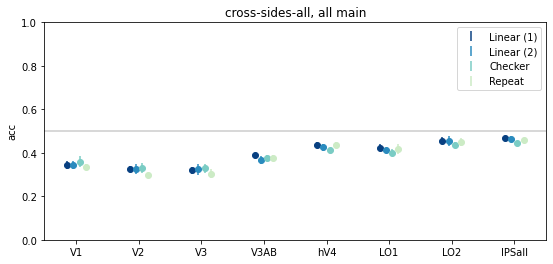

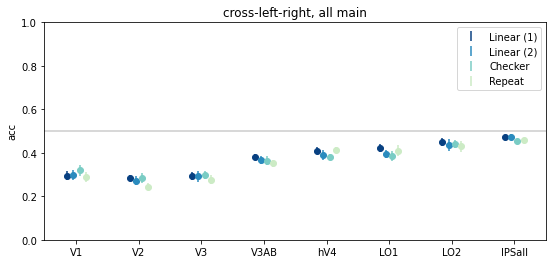

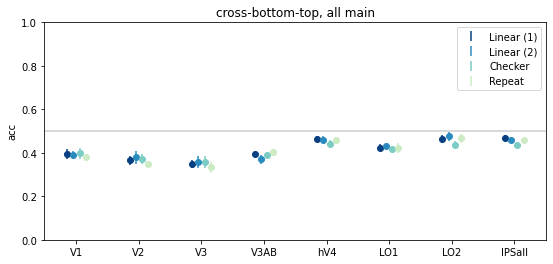

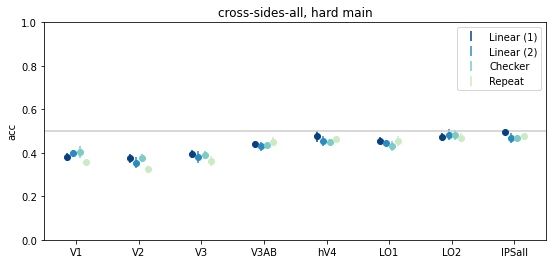

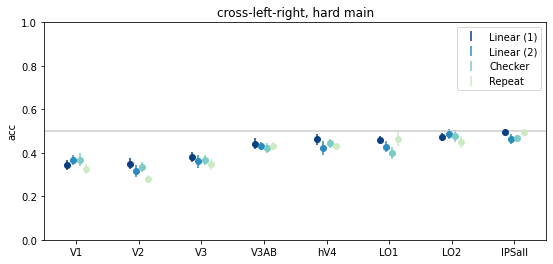

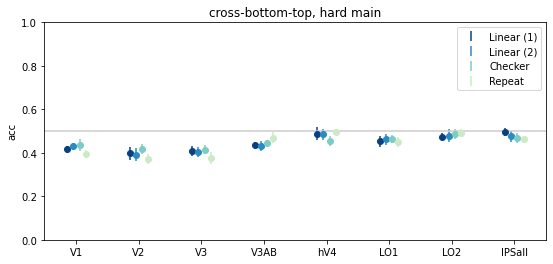

In [25]:
for tgi, tgname in enumerate(trial_group_names):

    for [vals, name] in zip([np.mean(across_side_acc[:,:,:,:,tgi], axis=3), \
                            np.mean(across_side_acc[:,:,:,[0,1],tgi], axis=3), \
                            np.mean(across_side_acc[:,:,:,[2,3],tgi], axis=3)], \
                             ['cross-sides-all','cross-left-right','cross-bottom-top']):

        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)

        x_jitter = np.linspace(-0.15, 0.15, 4)

        plt.figure(figsize=(9,4))

        plt.axhline(0.5, color=[0.8, 0.8, 0.8])

        lh = []

        # non_overlapping = (cilow[:,0,ii] > cihigh[:,1,ii]) | (cilow[:,1,ii] > cihigh[:,0,ii])

        for ti in [0,1,2,3]:

            x_ticks = np.arange(n_rois) + x_jitter[ti]

            plt.plot(x_ticks, meanvals[:,ti], 'o',color=task_colors[ti])
            h = plt.errorbar(x_ticks, meanvals[:,ti], \
                             semvals[:,ti], \
                             xerr=None, color=task_colors[ti], linestyle='none')
            lh.append(h)

        plt.ylim([0, 1])

        plt.xticks(np.arange(n_rois), roi_names)
        plt.ylabel('acc')

        plt.legend(lh,task_names)

        plt.title('%s, %s'%(name,tgname))
    

Text(0.5, 1.0, 'across-sides bottom-top')

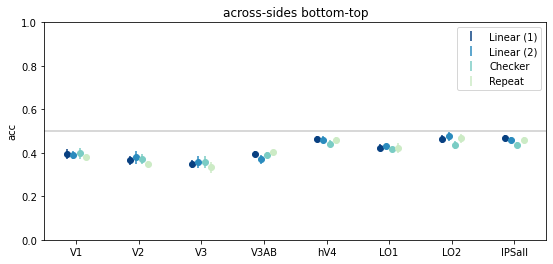

In [15]:
vals = np.mean(across_side_acc[:,:,:,[2,3]], axis=3)
meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)

x_jitter = np.linspace(-0.15, 0.15, 4)

plt.figure(figsize=(9,4))

plt.axhline(0.5, color=[0.8, 0.8, 0.8])

lh = []

# non_overlapping = (cilow[:,0,ii] > cihigh[:,1,ii]) | (cilow[:,1,ii] > cihigh[:,0,ii])

for ti in [0,1,2,3]:

    x_ticks = np.arange(n_rois) + x_jitter[ti]

    plt.plot(x_ticks, meanvals[:,ti], 'o',color=task_colors[ti])
    h = plt.errorbar(x_ticks, meanvals[:,ti], \
                     semvals[:,ti], \
                     xerr=None, color=task_colors[ti], linestyle='none')
    lh.append(h)

plt.ylim([0, 1])

plt.xticks(np.arange(n_rois), roi_names)
plt.ylabel('acc')

plt.legend(lh,task_names)

plt.title('across-sides bottom-top')
    

Text(0.5, 1.0, 'across-sides all')

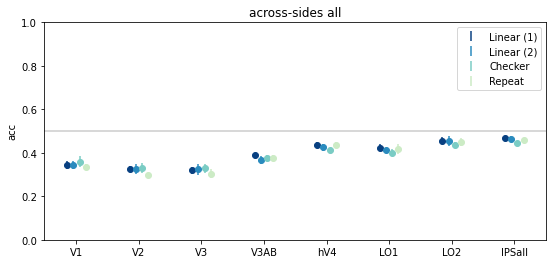

In [13]:
vals = np.mean(across_side_acc, axis=3)
meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)

x_jitter = np.linspace(-0.15, 0.15, 4)

plt.figure(figsize=(9,4))

plt.axhline(0.5, color=[0.8, 0.8, 0.8])

lh = []

# non_overlapping = (cilow[:,0,ii] > cihigh[:,1,ii]) | (cilow[:,1,ii] > cihigh[:,0,ii])

for ti in [0,1,2,3]:

    x_ticks = np.arange(n_rois) + x_jitter[ti]

    plt.plot(x_ticks, meanvals[:,ti], 'o',color=task_colors[ti])
    h = plt.errorbar(x_ticks, meanvals[:,ti], \
                     semvals[:,ti], \
                     xerr=None, color=task_colors[ti], linestyle='none')
    lh.append(h)

plt.ylim([0, 1])

plt.xticks(np.arange(n_rois), roi_names)
plt.ylabel('acc')

plt.legend(lh,task_names)

plt.title('across-sides all')
    

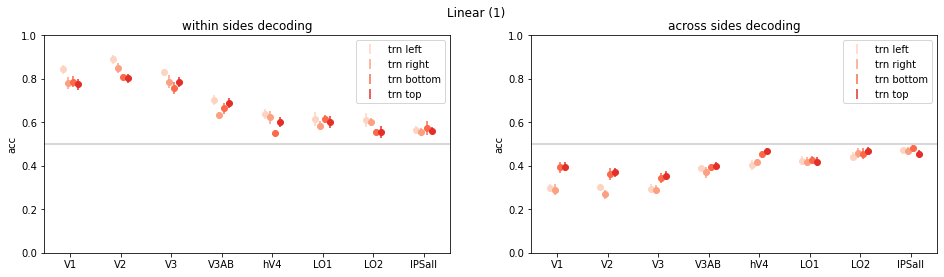

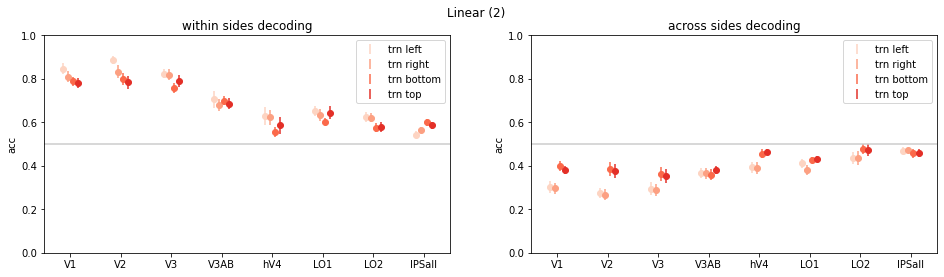

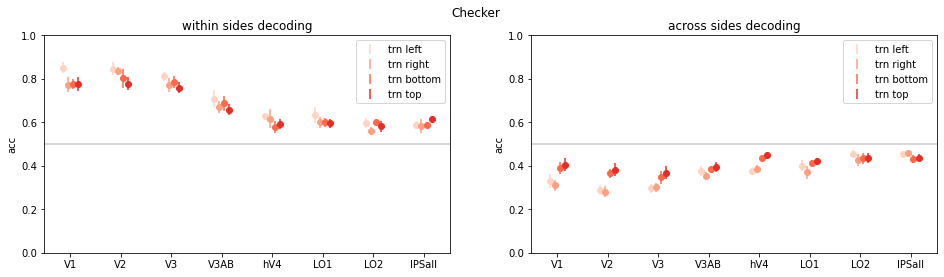

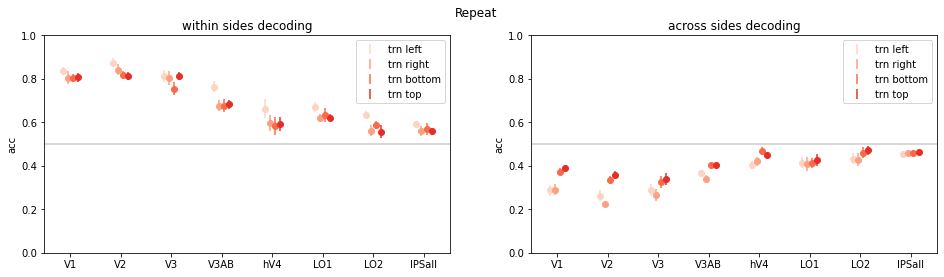

In [9]:
colors = cm.Reds(np.linspace(0,1,7))[1:5,:]


x_jitter = np.linspace(-0.15, 0.15, 4)
   
for ti in range(4):

    plt.figure(figsize=(16,4))

    for xx, [avals,name] in enumerate(zip([within_side_acc, across_side_acc], \
                                          ['within','across'])):

        plt.subplot(1,2,xx+1)

        plt.axhline(0.5, color=[0.8, 0.8, 0.8])

        lh = []

        for tri in range(4):

            vals = avals[:,:,ti,tri]

            x_ticks = np.arange(n_rois) + x_jitter[tri]

            meanvals = np.mean(vals, axis=0)
            semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

            plt.plot(x_ticks, meanvals, 'o', color=colors[tri])
            h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=colors[tri], linestyle='none')
            lh.append(h)

        plt.ylim([0, 1])

        plt.xticks(np.arange(n_rois), roi_names)
        plt.ylabel('acc')

        plt.legend(lh,['trn %s'%ss for ss in trnsides])

        plt.title('%s sides decoding'%name)

    plt.suptitle(task_names[ti])

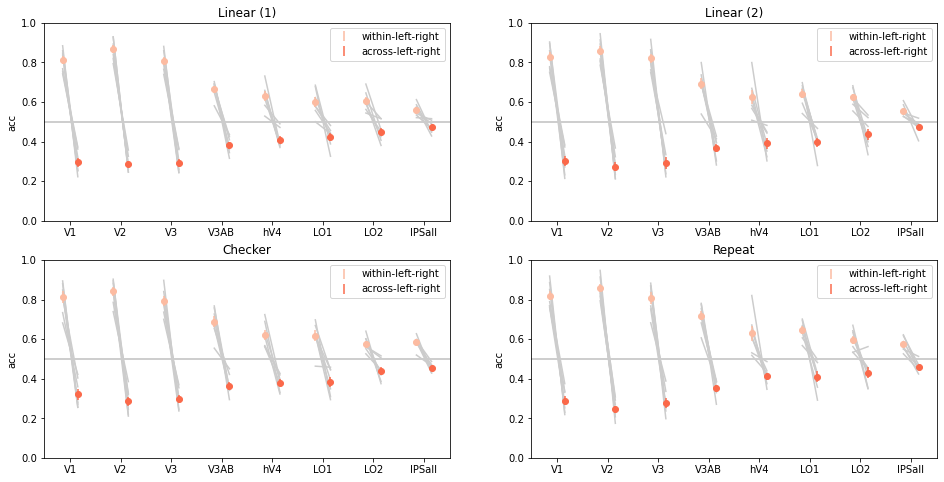

In [56]:

colors = cm.Reds(np.linspace(0,1,5))[1:3,:]

x_jitter = np.linspace(-0.15, 0.15, 2)

plt.figure(figsize=(16,8))
    
avals = np.concatenate([np.mean(within_side_acc[:,:,:,[0,1]], axis=3, keepdims=True), \
                       np.mean(across_side_acc[:,:,:,[0,1]], axis=3, keepdims=True)], axis=3)
   
for ti in range(4):

    plt.subplot(2,2,ti+1)

    lh = []

    for xx in [0,1]:

        plt.axhline(0.5, color=[0.8, 0.8, 0.8])

        
        vals = avals[:,:,ti,xx]

        x_ticks = np.arange(n_rois) + x_jitter[xx]

        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

        plt.plot(x_ticks, meanvals, 'o', color=colors[xx])
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=colors[xx], linestyle='none')
        lh.append(h)
        
    for ri in range(n_rois):
     
        plt.plot(ri+x_jitter, avals[:,ri,ti,:].T, color=[0.8, 0.8, 0.8], zorder=-10)
            

    plt.ylim([0, 1])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('acc')

    plt.legend(lh,['within-left-right','across-left-right'])

    plt.title('%s'%task_names[ti])


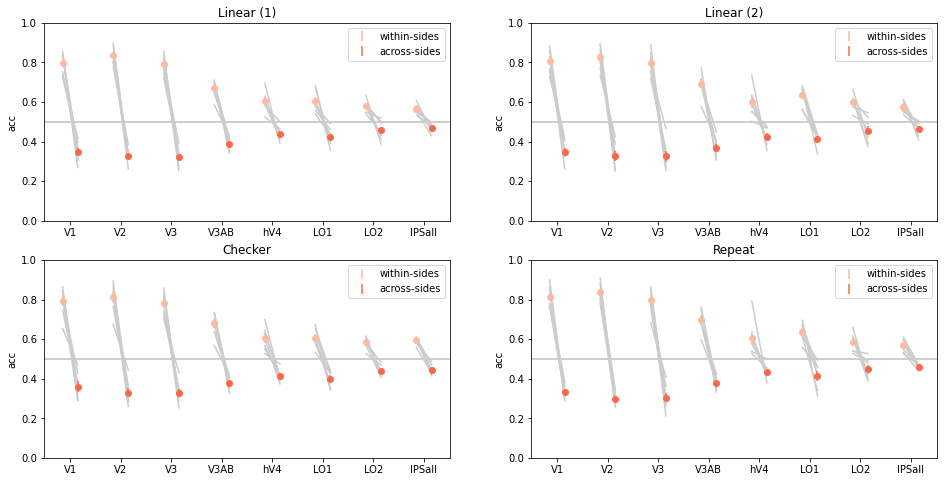

In [55]:
colors = cm.Reds(np.linspace(0,1,5))[1:3,:]

x_jitter = np.linspace(-0.15, 0.15, 2)

plt.figure(figsize=(16,8))
    
avals = np.concatenate([np.mean(within_side_acc, axis=3, keepdims=True), \
                       np.mean(across_side_acc, axis=3, keepdims=True)], axis=3)
   
for ti in range(4):

    plt.subplot(2,2,ti+1)

    lh = []

    for xx in [0,1]:

        plt.axhline(0.5, color=[0.8, 0.8, 0.8])

        
        vals = avals[:,:,ti,xx]

        x_ticks = np.arange(n_rois) + x_jitter[xx]

        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

        plt.plot(x_ticks, meanvals, 'o', color=colors[xx])
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=colors[xx], linestyle='none')
        lh.append(h)
        
    for ri in range(n_rois):
     
        plt.plot(ri+x_jitter, avals[:,ri,ti,:].T, color=[0.8, 0.8, 0.8], zorder=-10)
            

    plt.ylim([0, 1])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('acc')

    plt.legend(lh,['within-sides','across-sides'])

    plt.title('%s'%task_names[ti])


In [32]:
within_side_acc = np.zeros((n_subjects, n_rois, n_tasks, n_trnsides))
across_side_acc = np.zeros((n_subjects, n_rois, n_tasks, n_trnsides))

for si, ss in enumerate(subjects):

    # loop over tasks
    for ti, tt in enumerate([1,2,3,4]):
        
        l = lab[ss][lab[ss]['task']==tt]
        
        pt_labs = np.array([l['ptx'], l['pty']]).T
        
        # category is always checkerboard task here
        categ_actual = grid_utils.get_categ(pt_labs, task_num=3)
        
        is_main_grid = l['is_main_grid']==1
        
        center_pos = np.all(np.abs(pt_labs-2.5)<0.79, axis=1)
        print(ti, np.mean(center_pos))
        
        
        for tri in range(n_trnsides):
            
            if trnsides[tri]=='left':
                pt_inds_trn = pt_labs[:,0]<2.5
            elif trnsides[tri]=='right':
                pt_inds_trn = pt_labs[:,0]>2.5
            elif trnsides[tri]=='bottom':
                pt_inds_trn = pt_labs[:,1]<2.5
            elif trnsides[tri]=='top':
                pt_inds_trn = pt_labs[:,1]>2.5
            
            within_inds = pt_inds_trn & center_pos
            across_inds = ~pt_inds_trn & center_pos
            
            for ri in range(n_rois):

                pred = dec_withintask['preds_all'][si][ri][ti][tri].astype(int)
                
                inds = within_inds
                within_side_acc[si,ri,ti,tri] = np.mean(pred[inds]==categ_actual[inds])
                
                inds = across_inds
                across_side_acc[si,ri,ti,tri] = np.mean(pred[inds]==categ_actual[inds])

0 0.10243055555555555
1 0.10243055555555555
2 0.03993055555555555
3 0.005208333333333333
0 0.08506944444444445
1 0.10069444444444445
2 0.06770833333333333
3 0.006944444444444444
0 0.10590277777777778
1 0.0920138888888889
2 0.050347222222222224
3 0.006944444444444444
0 0.0954861111111111
1 0.09722222222222222
2 0.06597222222222222
3 0.010416666666666666
0 0.07291666666666667
1 0.08680555555555555
2 0.07118055555555555
3 0.006944444444444444
0 0.07916666666666666
1 0.078125
2 0.0625
3 0.005681818181818182
0 0.09722222222222222
1 0.10590277777777778
2 0.03993055555555555
3 0.01488095238095238


/usr/local/serenceslab/maggie/conda_envs/shape_dim/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/serenceslab/maggie/conda_envs/shape_dim/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/usr/local/serenceslab/maggie/conda_envs/shape_dim/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/usr/local/serenceslab/maggie/conda_envs/shape_dim/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


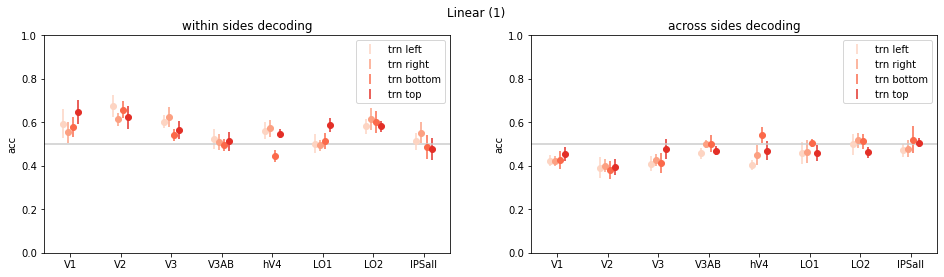

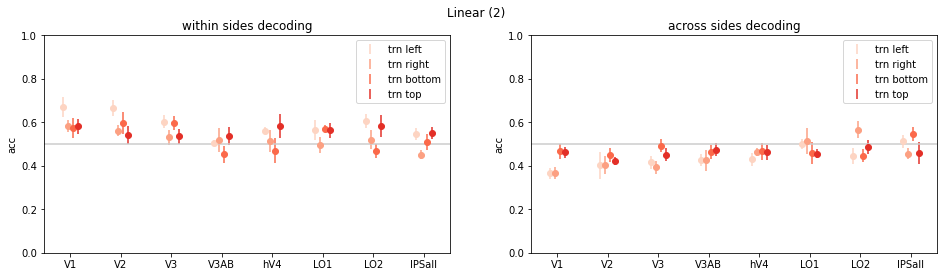

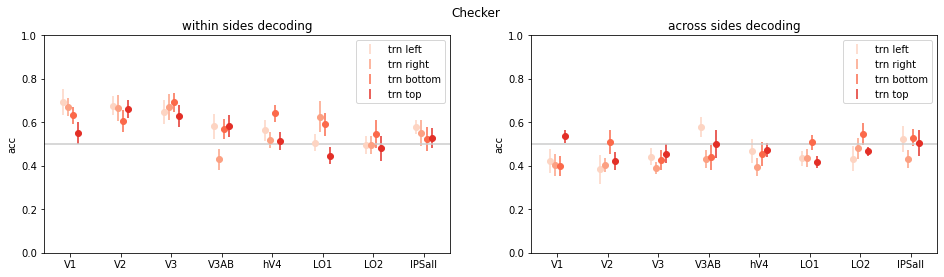

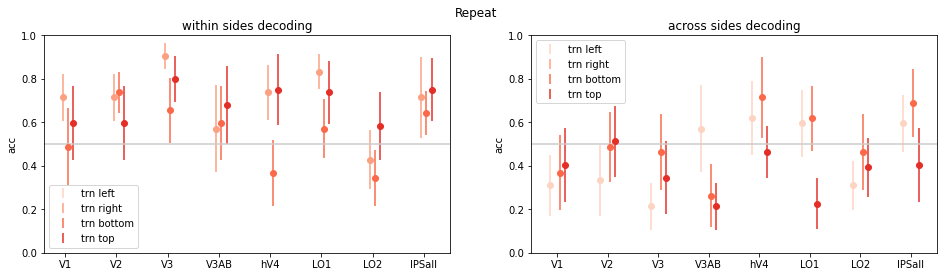

In [36]:
colors = cm.Reds(np.linspace(0,1,7))[1:5,:]


x_jitter = np.linspace(-0.15, 0.15, 4)
   
for ti in range(4):

    plt.figure(figsize=(16,4))

    for xx, [avals,name] in enumerate(zip([within_side_acc, across_side_acc], \
                                          ['within','across'])):

        plt.subplot(1,2,xx+1)

        plt.axhline(0.5, color=[0.8, 0.8, 0.8])

        lh = []

        for tri in range(4):

            vals = avals[:,:,ti,tri]

            x_ticks = np.arange(n_rois) + x_jitter[tri]

            meanvals = np.mean(vals, axis=0)
            semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

            plt.plot(x_ticks, meanvals, 'o', color=colors[tri])
            h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=colors[tri], linestyle='none')
            lh.append(h)

        plt.ylim([0, 1])

        plt.xticks(np.arange(n_rois), roi_names)
        plt.ylabel('acc')

        plt.legend(lh,['trn %s'%ss for ss in trnsides])

        plt.title('%s sides decoding'%name)

    plt.suptitle(task_names[ti])

/usr/local/serenceslab/maggie/conda_envs/shape_dim/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/usr/local/serenceslab/maggie/conda_envs/shape_dim/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


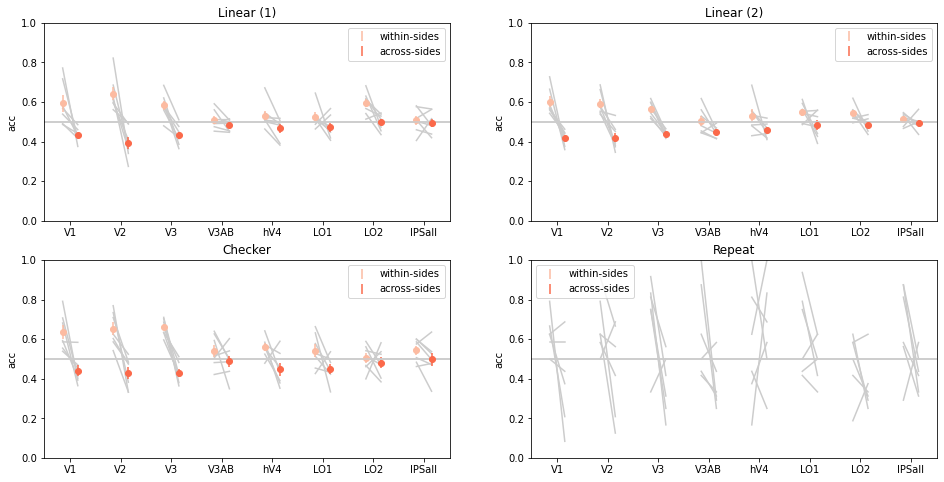

In [34]:
colors = cm.Reds(np.linspace(0,1,5))[1:3,:]

x_jitter = np.linspace(-0.15, 0.15, 2)

plt.figure(figsize=(16,8))
    
avals = np.concatenate([np.mean(within_side_acc, axis=3, keepdims=True), \
                       np.mean(across_side_acc, axis=3, keepdims=True)], axis=3)
   
for ti in range(4):

    plt.subplot(2,2,ti+1)

    lh = []

    for xx in [0,1]:

        plt.axhline(0.5, color=[0.8, 0.8, 0.8])

        
        vals = avals[:,:,ti,xx]

        x_ticks = np.arange(n_rois) + x_jitter[xx]

        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

        plt.plot(x_ticks, meanvals, 'o', color=colors[xx])
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=colors[xx], linestyle='none')
        lh.append(h)
        
    for ri in range(n_rois):
     
        plt.plot(ri+x_jitter, avals[:,ri,ti,:].T, color=[0.8, 0.8, 0.8], zorder=-10)
            

    plt.ylim([0, 1])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('acc')

    plt.legend(lh,['within-sides','across-sides'])

    plt.title('%s'%task_names[ti])
